In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [19]:
df= pd.read_csv('D:\THESIS WORK(indoorcoverage)\ThesisProject\data\data-2\data2.csv')


In [20]:
df.head()

,X,Y,Z,AP1,AP2,AP3,AP4,AP5,AP6,AP7,...,AP480,AP481,AP482,AP483,AP484,AP485,AP486,AP487,AP488,AP489
0,172.94,72.043,0.0,100.0,100.0,100,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,172.94,77.043,0.0,100.0,100.0,100,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,167.94,77.043,0.0,100.0,100.0,100,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,167.94,82.043,0.0,100.0,100.0,100,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,167.94,87.043,0.0,100.0,100.0,100,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [21]:
df.columns

Index(['X', 'Y', 'Z', 'AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7',
       ...
       'AP480', 'AP481', 'AP482', 'AP483', 'AP484', 'AP485', 'AP486', 'AP487',
       'AP488', 'AP489'],
      dtype='object', length=492)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Columns: 492 entries, X to AP489
dtypes: float64(447), int64(45)
memory usage: 5.4 MB


In [24]:
X = df.drop(columns=['X', 'Y', 'Z'])
y = df[['X', 'Y', 'Z']]

In [49]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Check the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1142, 489)
y_train shape: (1142, 3)
X_test shape: (286, 489)
y_test shape: (286, 3)


In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Convert DataFrame to NumPy array and reshape for LSTM/TCN/CNN input
X_train_seq = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_seq = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
print("X_train shape:", X_train.shape)  # Should be (samples, 1, features)
print("y_train shape:", y_train.shape)  # Should be (samples, 3)

X_train shape: (1142, 489)
y_train shape: (1142, 3)


In [54]:
from tensorflow.keras import models
from tensorflow.keras import layers
def build_bilstm():
    model = models.Sequential([
        layers.Input(shape=(1, X_train.shape[1])),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
        layers.Dense(32, activation='relu'),
        layers.Dense(3)  # X, Y
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [55]:
def build_transformer():
    input_layer = Input(shape=(1, X_train.shape[1]))
    x = layers.Dense(64)(input_layer)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    output = layers.Dense(3)(x)
    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [56]:
# !pip install keras-tcn
from tcn import TCN

def build_tcn():
    model = models.Sequential([
        TCN(input_shape=(1, X_train.shape[1]), nb_filters=64),
        layers.Dense(32, activation='relu'),
        layers.Dense(3)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [58]:
def build_cnn_lstm():
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=1, activation='relu', input_shape=(1, X_train.shape[1])),
        layers.MaxPooling1D(pool_size=1),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(3)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [59]:
def train_xgboost():
    xgb_x = xgb.XGBRegressor()
    xgb_y = xgb.XGBRegressor()
    xgb_x.fit(X_train, y_train[:, 0])
    xgb_y.fit(X_train, y_train[:, 1])
    pred_x = xgb_x.predict(X_test)
    pred_y = xgb_y.predict(X_test)
    return np.column_stack([pred_x, pred_y])


In [60]:
def build_autoencoder_regression():
    input_seq = Input(shape=(1, X_train.shape[1]))
    encoded = layers.LSTM(64)(input_seq)
    decoded = layers.RepeatVector(1)(encoded)
    decoded = layers.LSTM(X_train.shape[1], return_sequences=True)(decoded)
    regression = layers.Dense(3)(encoded)
    model = models.Model(inputs=input_seq, outputs=regression)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [61]:
from sklearn.metrics import r2_score
models_list = {
    'BiLSTM': build_bilstm(),
    'Transformer': build_transformer(),
    'CNN+LSTM': build_cnn_lstm(),
    'Autoencoder': build_autoencoder_regression()
}

results = []

for name, model in models_list.items():
    print(f"\nTraining {name}...")
    history = model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test),
                        epochs=20, batch_size=32, verbose=0)

    # Predictions
    y_train_pred = model.predict(X_train_seq)
    y_test_pred = model.predict(X_test_seq)

    # Evaluation
    loss, mae = model.evaluate(X_test_seq, y_test, verbose=0)
    train_loss, train_mae = model.evaluate(X_train_seq, y_train, verbose=0)

    # R2 and RMSE
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results.append({
        'Model': name,
        'Train Loss': train_loss,
        'Test Loss': loss,
        'Train MAE': train_mae,
        'Test MAE': mae,
        'Train R2': r2_train,
        'Test R2': r2_test,
        'Train RMSE': rmse_train,
        'Test RMSE': rmse_test
    })


d:\THESIS WORK(indoorcoverage)\ThesisProject\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training BiLSTM...
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Training Transformer...
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Training CNN+LSTM...
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Training Autoencoder...
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import xgboost as xgb

def train_xgboost():
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    return model

# Train
xgb_model = train_xgboost()

# Predictions
xgb_train_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)

# Train Metrics
mse_train_xgb = mean_squared_error(y_train, xgb_train_preds)
mae_train_xgb = mean_absolute_error(y_train, xgb_train_preds)
r2_train_xgb = r2_score(y_train, xgb_train_preds)
rmse_train_xgb = np.sqrt(mse_train_xgb)

# Test Metrics
mse_test_xgb = mean_squared_error(y_test, xgb_test_preds)
mae_test_xgb = mean_absolute_error(y_test, xgb_test_preds)
r2_test_xgb = r2_score(y_test, xgb_test_preds)
rmse_test_xgb = np.sqrt(mse_test_xgb)

# Append to results
results.append({
    'Model': 'XGBoost',
    'Train Loss': mse_train_xgb,
    'Test Loss': mse_test_xgb,
    'Train MAE': mae_train_xgb,
    'Test MAE': mae_test_xgb,
    'Train R2': r2_train_xgb,
    'Test R2': r2_test_xgb,
    'Train RMSE': rmse_train_xgb,
    'Test RMSE': rmse_test_xgb
})


In [64]:
results_df = pd.DataFrame(results)
results_df

,Model,Train Loss,Test Loss,Train MAE,Test MAE,Train R2,Test R2,Train RMSE,Test RMSE
0,BiLSTM,912.826843,883.104004,21.436817,21.071341,-0.000608,-0.000128,30.213032,29.717069
1,Transformer,30.637495,37.089157,3.880802,4.173428,0.633269,0.578935,5.535115,6.090087
2,CNN+LSTM,918.427429,887.059998,21.595516,21.188902,-0.005682,-0.005198,30.305560,29.783553
3,Autoencoder,15074.257812,15137.869141,93.154800,93.682907,-13.564003,-15.140273,122.777329,123.036036
4,XGBoost,1.757378,20.038919,0.813013,2.337092,0.995407,0.965647,1.325661,4.476485


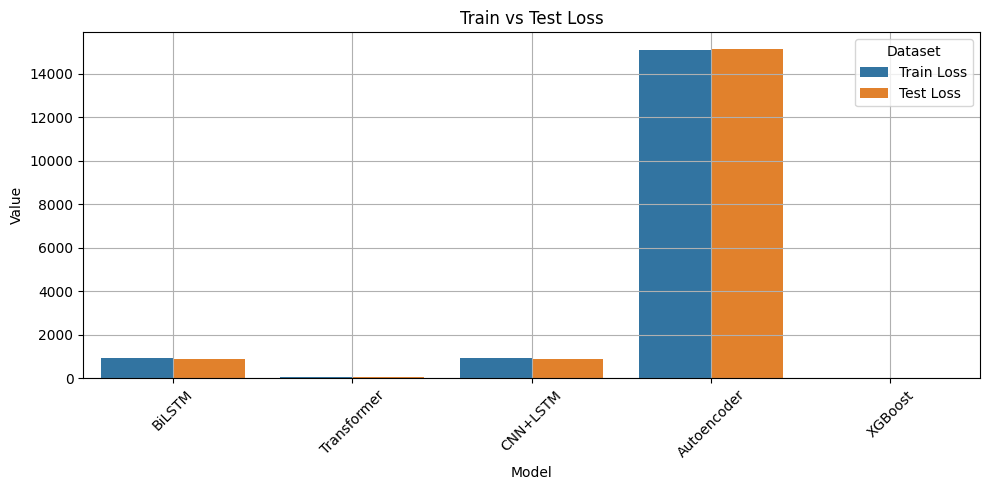

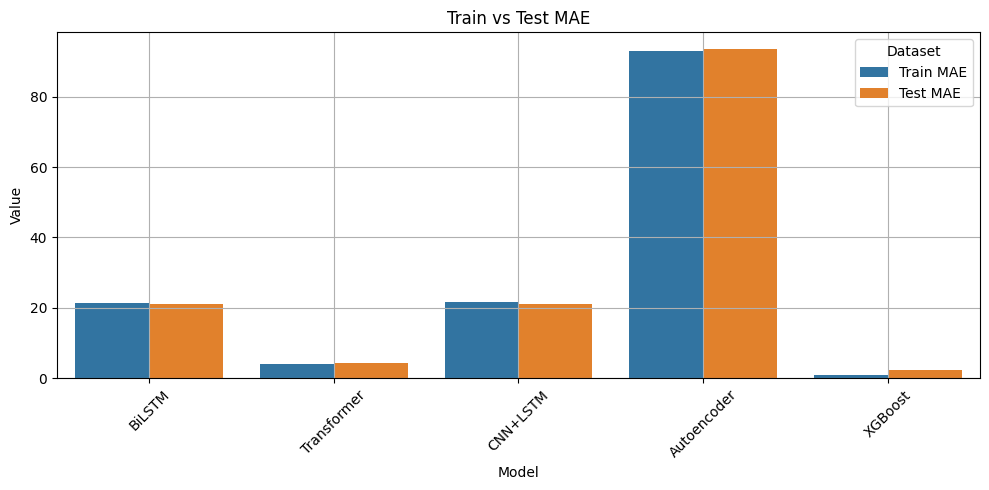

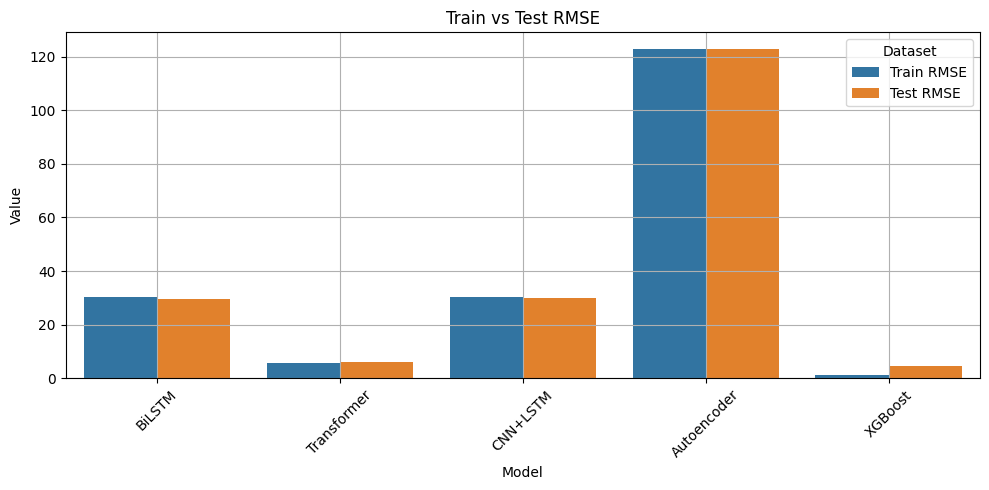

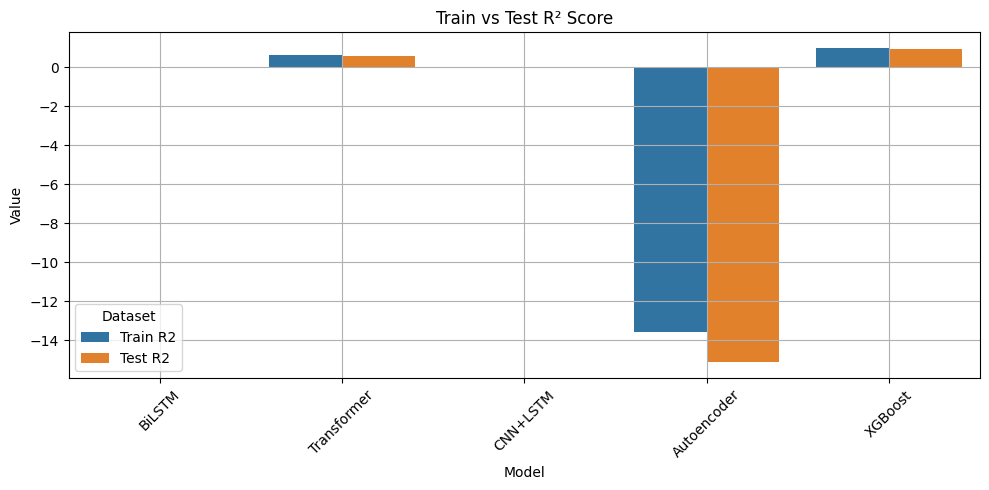

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to DataFrame if not already
results_df = pd.DataFrame(results)

# Round for cleaner display
results_df_rounded = results_df.round(4)

# Plot function
def plot_metric_pair(df, train_metric, test_metric, title):
    melted_df = df[['Model', train_metric, test_metric]].melt(id_vars='Model', var_name='Dataset', value_name='Value')

    plt.figure(figsize=(10, 5))
    sns.barplot(data=melted_df, x='Model', y='Value', hue='Dataset')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# 🔢 Plotting all relevant metric pairs
plot_metric_pair(results_df_rounded, 'Train Loss', 'Test Loss', 'Train vs Test Loss')
plot_metric_pair(results_df_rounded, 'Train MAE', 'Test MAE', 'Train vs Test MAE')
plot_metric_pair(results_df_rounded, 'Train RMSE', 'Test RMSE', 'Train vs Test RMSE')
plot_metric_pair(results_df_rounded, 'Train R2', 'Test R2', 'Train vs Test R² Score')
